In [2]:
from sentinelhub import SHConfig

config = SHConfig()

config.instance_id = '<your instance id>'
config.sh_client_id = "eff495cd-ca8e-4fe7-bc30-307b616e4d13"
config.sh_client_secret = ".tAvAgo5M>@Gvo^EWfX-d)y6:OB@}JN^-C46c(-N"

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import datetime
import os

import itertools
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import MultiLineString, MultiPolygon, Polygon, box, shape

from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    DataCollection,
    MimeType,
    MosaickingOrder,
    OsmSplitter,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    read_data,
    bbox_to_dimensions,
    SentinelHubCatalog
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image
from tqdm import tqdm

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap

## Định nghĩa geo_location cho khu vực quan tâm

In [6]:
INPUT_FILE = "./data/Southeast_Asia.json"

geo_json = read_data(INPUT_FILE)
sea_area = shape(geo_json["features"][0]["geometry"])

type(sea_area)

shapely.geometry.polygon.Polygon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


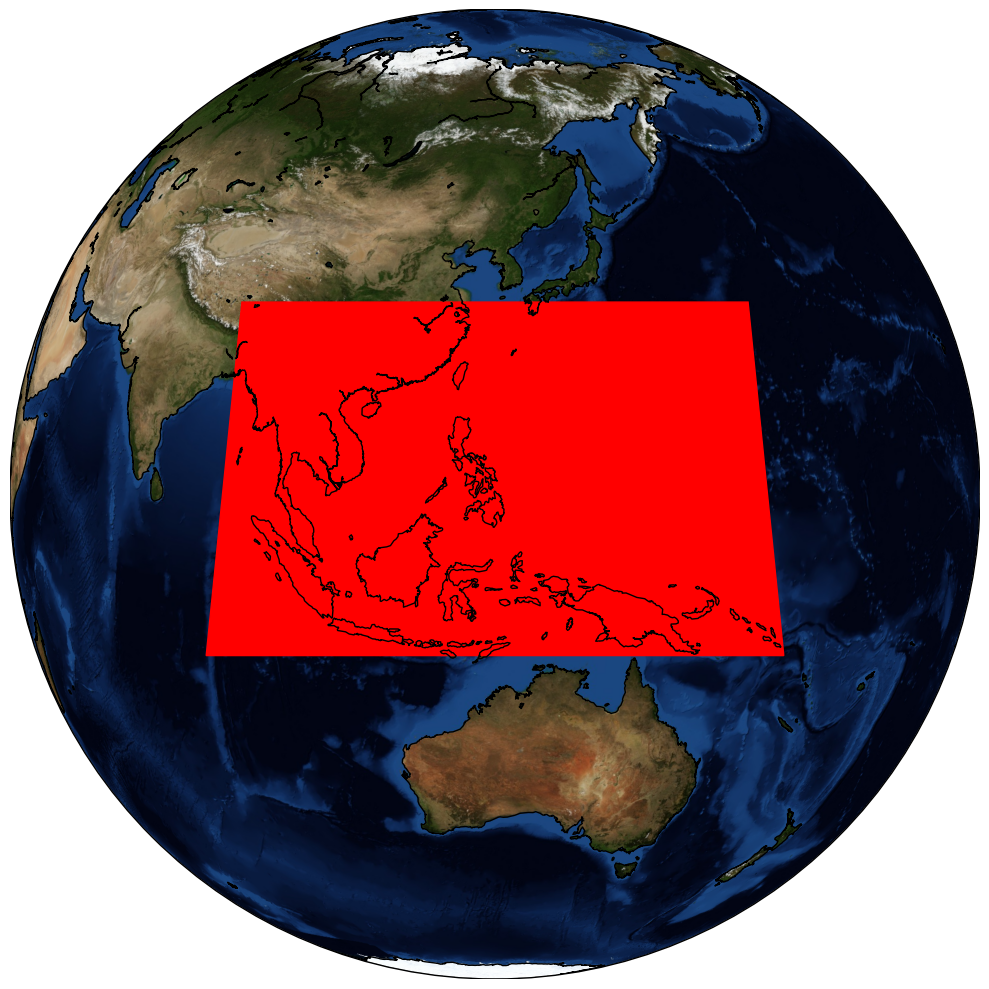

In [7]:
### infer for test
def show_area(area_shape, area_buffer=0.3):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2

    m = Basemap(projection="ortho", lat_0=lat, lon_0=lng, resolution="l")
    m.drawcoastlines()
    m.bluemarble()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        x, y = np.array(polygon.boundary.coords)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary.coords):
            m_poly.append(m(x, y))
        ax.add_patch(plt_polygon(np.array(m_poly), closed=True, facecolor="red", edgecolor="red"))

    plt.tight_layout()
    plt.show()



show_area(sea_area)

## Chia thành các bbox nhỏ hơn

In [8]:
grid_size = (80, 80)
bbox_splitter = BBoxSplitter(
    [sea_area], CRS.WGS84, grid_size
)  # bounding box will be split into grid of 5x4 bounding boxes

print("Area bounding box: {}\n".format(bbox_splitter.get_area_bbox().__repr__()))

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print(
    "Each bounding box also has some info how it was created.\nExample:\nbbox: {}\ninfo: {}\n".format(
        bbox_list[0].__repr__(), info_list[0]
    )
)

Area bounding box: BBox(((88.0, -12.0), (163.0, 31.0)), crs=CRS('4326'))

Each bounding box also has some info how it was created.
Example:
bbox: BBox(((88.0, -12.0), (88.9375, -11.4625)), crs=CRS('4326'))
info: {'parent_bbox': BBox(((88.0, -12.0), (163.0, 31.0)), crs=CRS('4326')), 'index_x': 0, 'index_y': 0}



In [9]:
bbox_splitter.get_bbox_list()[:5]

[BBox(((88.0, -12.0), (88.9375, -11.4625)), crs=CRS('4326')),
 BBox(((88.0, -11.4625), (88.9375, -10.925)), crs=CRS('4326')),
 BBox(((88.0, -10.925), (88.9375, -10.3875)), crs=CRS('4326')),
 BBox(((88.0, -10.3875), (88.9375, -9.85)), crs=CRS('4326')),
 BBox(((88.0, -9.85), (88.9375, -9.3125)), crs=CRS('4326'))]

In [10]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

collection = DataCollection.SENTINEL2_L1C


def get_true_color_request(bbox, bbox_size, time_interval):
    return SentinelHubRequest(
        data_folder="images_data",
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=collection,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=bbox,
        size=bbox_size,
        config=config
    )


In [16]:
resolution = 60
time_interval = ("2023-03-25T00:00:00", "2023-03-25T23:59:59")
bboxes = bbox_splitter.get_bbox_list()

## Kiểm tra các boxes có data hay không, nhằm giảm dung lượng download

In [17]:
catalog = SentinelHubCatalog(config=config)
availabel_boxes = []
for i, box in tqdm(enumerate(bboxes), total=len(bboxes)):
    search_iterator = catalog.search(
        collection,
        bbox=box,
        time=time_interval,
        limit=1
    )
    result = list(search_iterator)
    if result:
        availabel_boxes.append(box)
    if i == 100:
        break
    


  2%|▏         | 100/6400 [03:24<3:34:56,  2.05s/it]


In [18]:
resolution = 60
time_interval = ("2023-03-25T00:00:00", "2023-03-25T23:59:59")
bboxes = bbox_splitter.get_bbox_list()
list_of_requests = []
for i, bbox in enumerate(availabel_boxes):
    bbox_size = bbox_to_dimensions(bbox, resolution=resolution)
    request = get_true_color_request(bbox, bbox_size, time_interval)
    list_of_requests.append(request.download_list[0])
    if i == 100:
        break
    
# download data with multiple threads   
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [19]:
len(data)

24

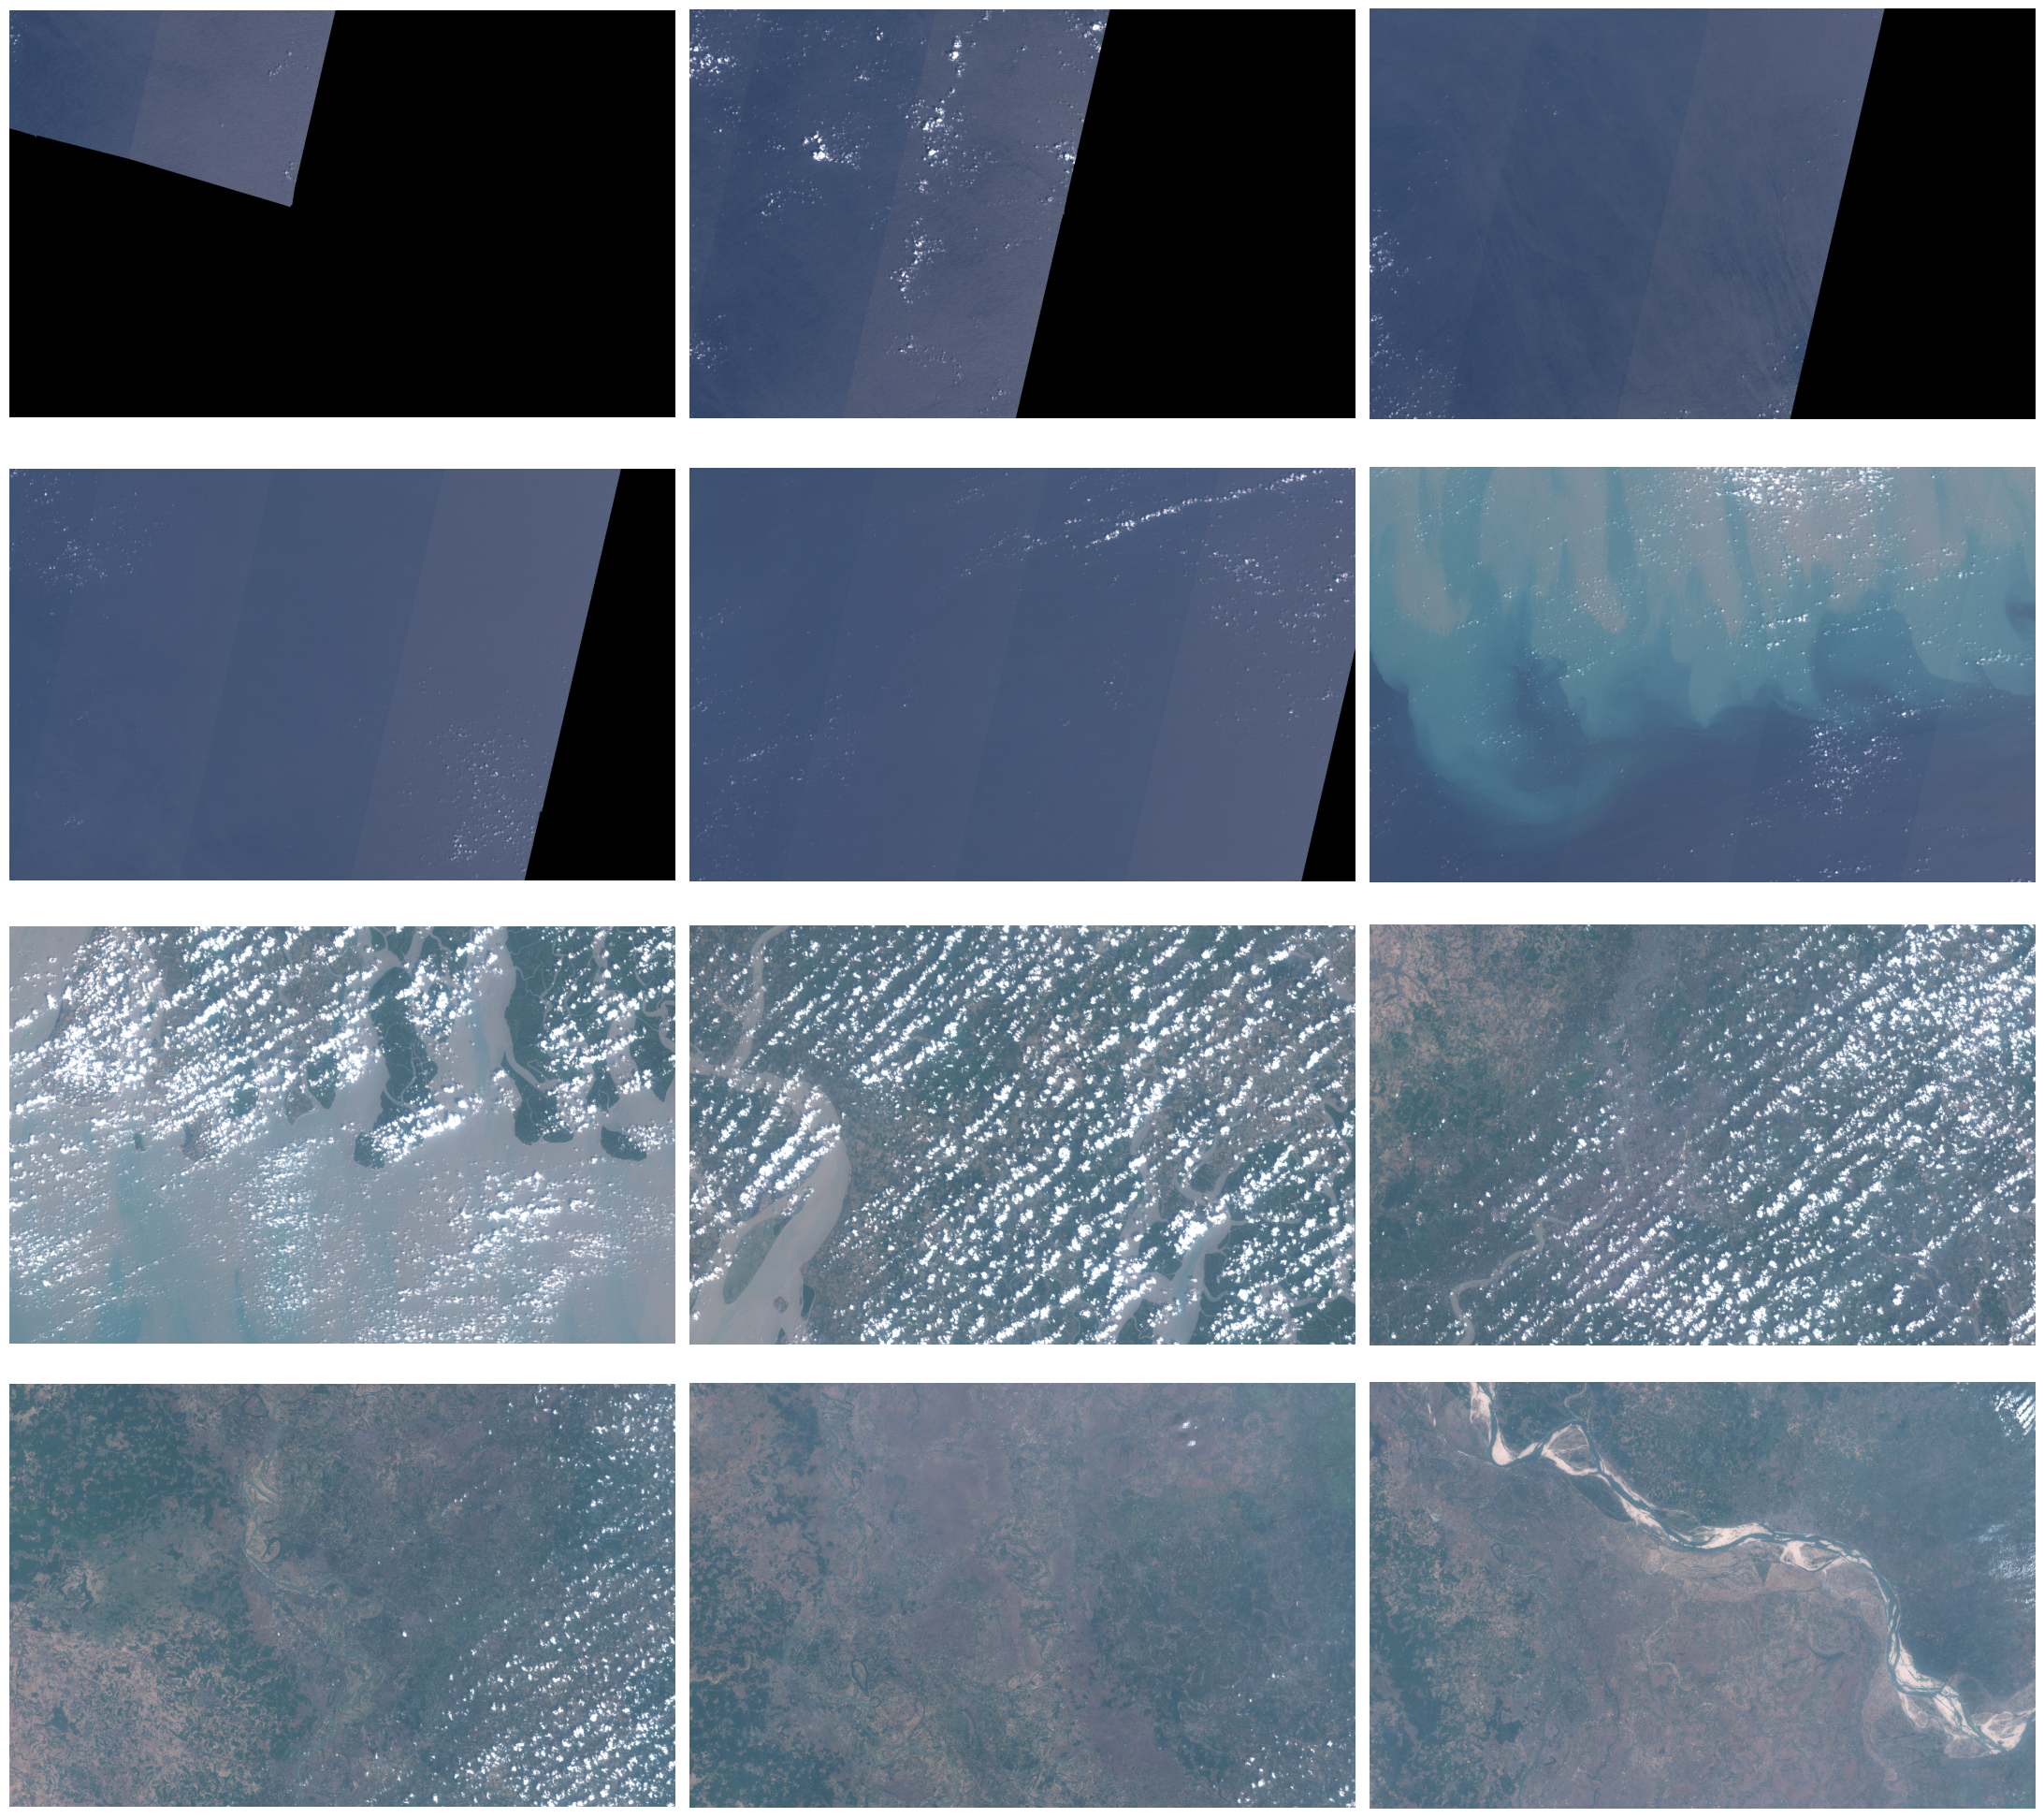

In [20]:
ncols = 3
nrows = 4
aspect_ratio = bbox_size[0] / bbox_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data[:12]):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 3.5 / 255, 0, 1))
    if idx == 11:
        break

plt.tight_layout()